In [47]:
import os #import module 
import numpy as np #import module 
import pandas as pd #import module 
from scipy import sparse #import module 
import matplotlib.pyplot as plt #import module 
from scipy.io import loadmat #import module 
from sklearn.model_selection import train_test_split #import module 
from sklearn.metrics import mean_absolute_error, mean_squared_error #import module 
from sklearn.ensemble import RandomForestRegressor #import module 
from sklearn.linear_model import Ridge #import module 

#shows zip file exists
os.listdir(".")

import zipfile #import module 

#finds zip file 
zip_file = [f for f in os.listdir(".") if f.endswith(".zip")][0]
print("Found zip file:", zip_file)

#shows which file is extracted 
with zipfile.ZipFile(zip_file, "r") as zip_ref:
    zip_ref.extractall("traffic_data")

#show files were extracted
print("extracted files:", os.listdir("traffic_data"))

#loads & shows file 
files = os.listdir("traffic_data")
print("Files:", files)

#finds & loads file 
mat_file = [f for f in files if f.endswith(".mat")][0]
data = loadmat("traffic_data/traffic_dataset.mat")

#shows variables 
keys = [k for k in data.keys() if not k.startswith("__")]
print("mat keys:", keys)

######################
X_train = data["tra_X_tr"]
X_test  = data["tra_X_te"]
y_train = data["tra_Y_tr"]
y_test  = data["tra_Y_te"]
A       = data["tra_adj_mat"]

#shows what was extracted 
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)
print("Adj A  :", A.shape)

#datas clean  
def densify(x):
    return x.toarray() if sparse.issparse(x) else np.asarray(x)

y_train = densify(data["tra_Y_tr"]).astype(np.float64)
y_test  = densify(data["tra_Y_te"]).astype(np.float64)

A = densify(data["tra_adj_mat"]).astype(np.float64)

print("y_train:", y_train.shape, y_train.dtype)
print("y_test :", y_test.shape, y_test.dtype)
print("a :", A.shape, A.dtype)

print("NaNs in y_train:", np.isnan(y_train).sum())
print("y_train min/max:", y_train.min(), y_train.max())

#shows datas prepped
Ytr = y_train.T
print("Ytr:", Ytr.shape)

Found zip file: traffic+flow+forecasting (2).zip
extracted files: ['__MACOSX', 'traffic_dataset.mat', 'Traffic Flow Prediction Dataset.docx']
Files: ['__MACOSX', 'traffic_dataset.mat', 'Traffic Flow Prediction Dataset.docx']
mat keys: ['tra_X_tr', 'tra_X_te', 'tra_Y_tr', 'tra_Y_te', 'tra_adj_mat']
X_train: (1, 1261)
y_train: (36, 1261)
X_test : (1, 840)
y_test : (36, 840)
Adj A  : (36, 36)
y_train: (36, 1261) float64
y_test : (36, 840) float64
a : (36, 36) float64
NaNs in y_train: 0
y_train min/max: 0.0 1.0
Ytr: (1261, 36)


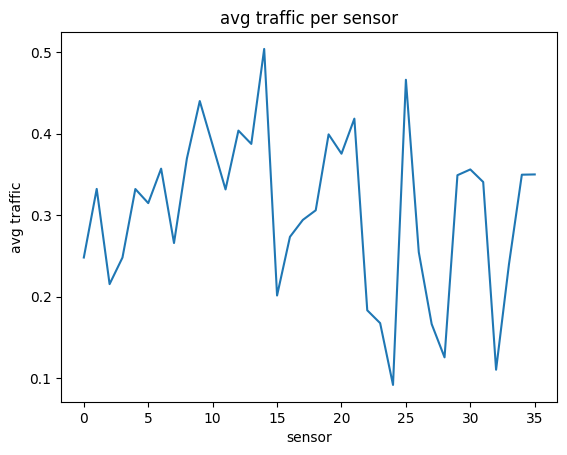

In [37]:
#sensor behavior EDA
plt.figure() #makes figure
plt.plot(Ytr.mean(axis=0)) #plot data
plt.title("avg traffic per sensor") #titles graph
plt.xlabel("sensor") #labels xaxis
plt.ylabel("avg traffic") #labels yaxis
plt.show() #shows graph 

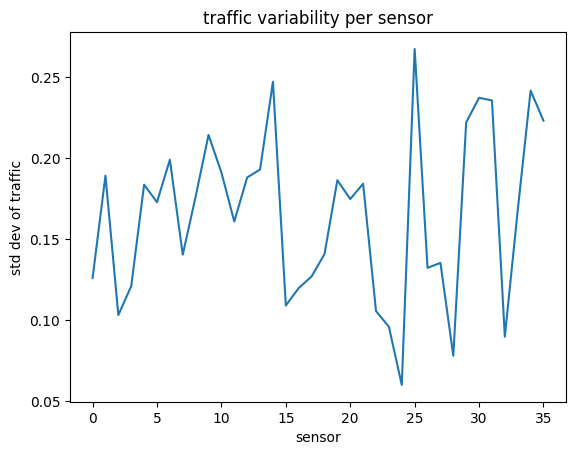

In [39]:
#traffic variability per sensor EDA
plt.figure() #makes figure
plt.plot(Ytr.std(axis=0)) #plot data 
plt.title("traffic variability per sensor") #titles graph 
plt.xlabel("sensor") #labels xaxis
plt.ylabel("std dev of traffic") #yaxis
plt.show() #shows graph 

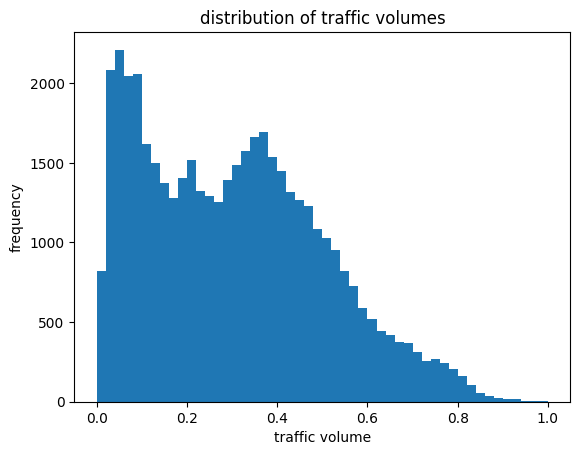

In [40]:
#distribution of traffic volumes EDA
plt.figure() #makes figure 
plt.hist(Ytr.flatten(), bins=50) #plots data
plt.title("distribution of traffic volumes") #titles graph
plt.xlabel("traffic volume") #labels xaxis
plt.ylabel("frequency") #labels yaxis
plt.show() #shows graph 

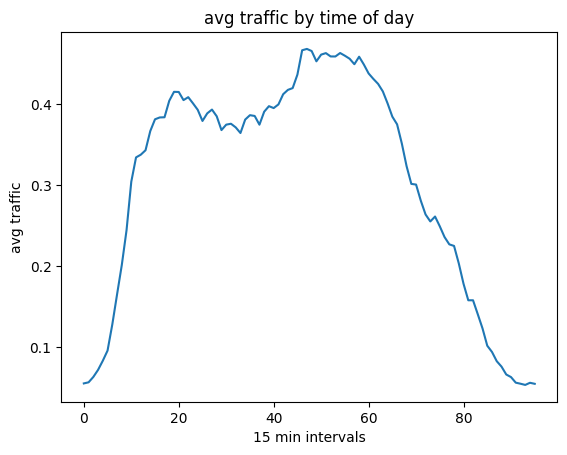

In [41]:
#sets intervals & points per day 
points_per_day = 96

#trims data 
T = (Ytr.shape[0] // points_per_day) * points_per_day
Ytrim = Ytr[:T]

#reshapes variables 
Ydays = Ytrim.reshape(-1, points_per_day, Ytr.shape[1])

#solves for avg traffic by time of day 
avg_by_time = Ydays.mean(axis=(0, 2))

#peak hours EDA
plt.figure() #makes figure 
plt.plot(avg_by_time) #plots data
plt.title("avg traffic by time of day") #titles graph
plt.xlabel("15 min intervals") #labels xaxis
plt.ylabel("avg traffic") #labels yaxis
plt.show() #shows graph 

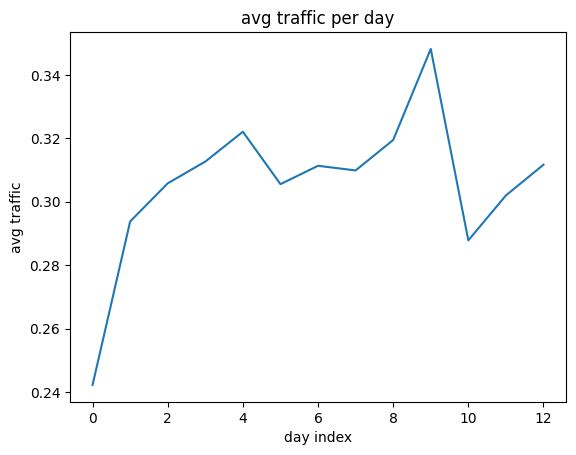

In [42]:
#solves for avg traffic daily
daily_avg = Ydays.mean(axis=(1,2))

#traffic pattern daily EDA
plt.figure() #makes figure
plt.plot(daily_avg) #plots data 
plt.title("avg traffic per day") #titles graph
plt.xlabel("day index") #labels xaxis
plt.ylabel("avg traffic") #labels yaxis
plt.show() #shows graph

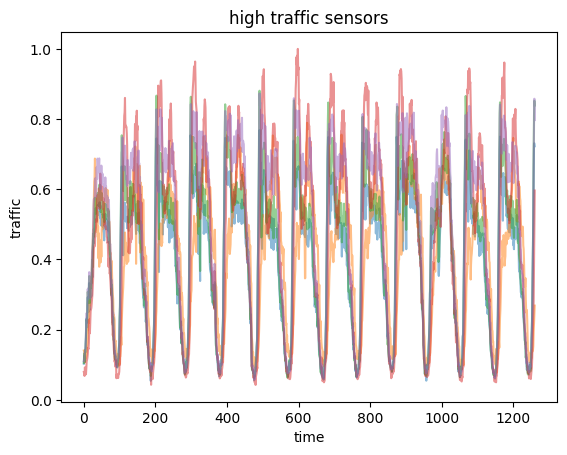

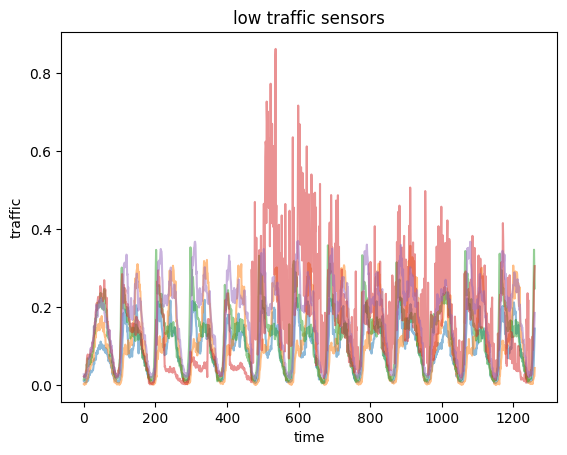

In [48]:
#solves for avg traffic per sensor
sensor_means = Ytr.mean(axis=0)

#shows 5 highest and lowest traffic sensors
top_sensors = np.argsort(sensor_means)[-5:]
low_sensors = np.argsort(sensor_means)[:5]

#makes figure
plt.figure()

#plot time series for high traffic sensors 
for s in top_sensors:
    plt.plot(Ytr[:, s], alpha=.5)
plt.title("high traffic sensors") #titles graph
plt.xlabel("time") #labels xaxis
plt.ylabel("traffic") #labels yaxis
plt.show() #shows graph 

#makes figure
plt.figure()

#plot time series for low traffic sensors 
for s in low_sensors:
    plt.plot(Ytr[:, s], alpha=.5)
plt.title("low traffic sensors")
plt.xlabel("time") #labels xaxis
plt.ylabel("traffic") #labels yaxis 
plt.show() #shows graph

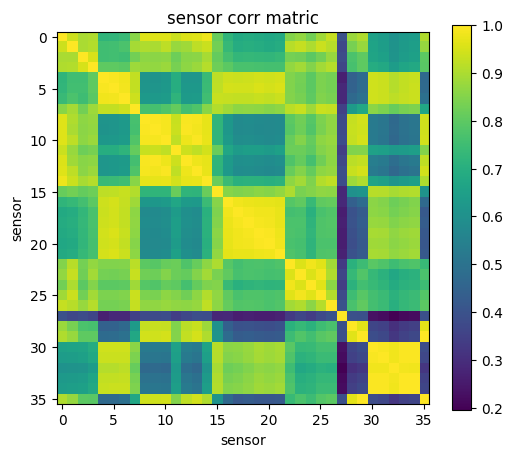

In [45]:
#solves for correlation w/ sensors
corr = np.corrcoef(Ytr.T)

#sensor correlation matrix EDA
plt.figure(figsize=(6, 5)) #makes figure size
plt.imshow(corr) #shows correlation
plt.colorbar() #makes colors
plt.title("sensor corr matric") #titles graph
plt.xlabel("sensor") #labels xaxis
plt.ylabel("sensor") #labels yaxis
plt.show() #shows graph

Ytr shape: (1261, 36)
Ydays shape: (13, 96, 36)
X_days shape: (13, 3456)
days per cluster: [9 2 2]


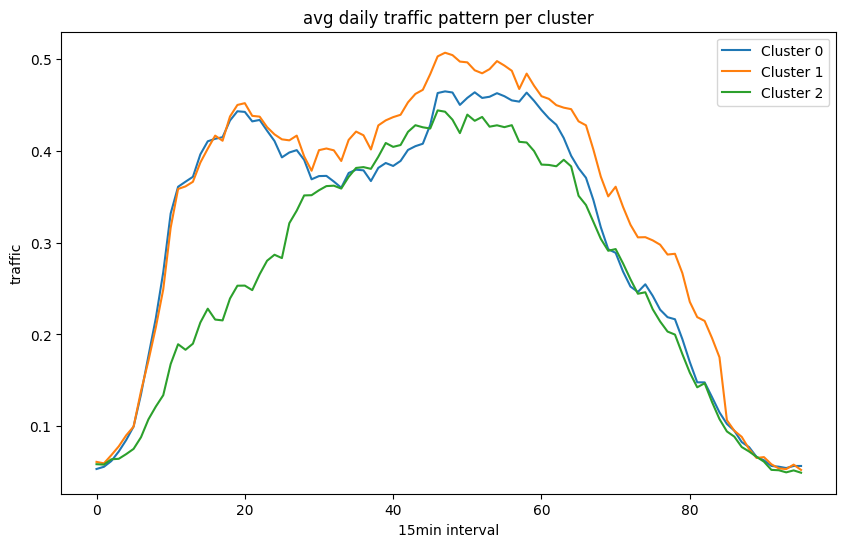

cluster 0:days=9,mean=0.31,peak=0.47,peak_interval=47
cluster 1:days=2,mean=0.34,peak=0.51,peak_interval=47
cluster 2:days=2,mean=0.27,peak=0.44,peak_interval=46


In [60]:
#shape data 
Ytr = y_train.T
print("Ytr shape:", Ytr.shape)

#set interval
points_per_day = 96

#trimming to full days 
T = (Ytr.shape[0] // points_per_day) * points_per_day
Ytrim = Ytr[:T]

#reshape daily blocks 
Ydays = Ytrim.reshape(-1, points_per_day, Ytr.shape[1])
print("Ydays shape:", Ydays.shape)

#flatten into one feature clustering 
X_days = Ydays.reshape(Ydays.shape[0], -1)
print("X_days shape:", X_days.shape)

from sklearn.preprocessing import StandardScaler #import module
from sklearn.cluster import KMeans #import module

#standardize features
scaler = StandardScaler()
X_days_scaled = scaler.fit_transform(X_days)

#running kmeans clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_days_scaled)

#shows how many days per cluster
print("days per cluster:", np.bincount(clusters))

#plots avg daily pattern of each cluster 
plt.figure(figsize=(10,6)) #makes figure
for c in range(3):
    mean_profile= Ydays[clusters == c].mean(axis=(0,2))
    plt.plot(mean_profile, label=f"Cluster {c}")

plt.legend() #makes legend 
plt.title("avg daily traffic pattern per cluster") #titles graph
plt.xlabel("15min interval") #labels xaxis
plt.ylabel("traffic") #labels yaxis 
plt.show() #shows graph 

#
for c in range(3):
    cluster_days = Ydays[clusters == c]

    num_days = cluster_days.shape[0]
    mean_traffic = cluster_days.mean()

    avg_daily_curve = cluster_days.mean(axis=(0, 2))
    peak_traffic = avg_daily_curve.max()
    peak_time = avg_daily_curve.argmax()

    print(
        f"cluster {c}:"
        f"days={num_days},"
        f"mean={mean_traffic:.2f},"
        f"peak={peak_traffic:.2f},"
        f"peak_interval={peak_time}"
    )